In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA

In [2]:
# extract raw data and epoch it 
raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)
events, event_id = mne.events_from_annotations(raw)

tmin = -0.05
tmax = 0.22

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=True)

Reading /Users/sashko/Documents/code/python/eeg_llm/sep_uwgr_prepro.fdt


/var/folders/88/5gz2l3qs4bz48czkqdqzhz1r0000gn/T/ipykernel_21856/3993384952.py:2: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)


Used Annotations descriptions: ['1']
Not setting metadata
6038 matching events found
No baseline correction applied
0 projection items activated
Loading data for 6038 events and 554 original time points ...
0 bad epochs dropped


In [21]:
# get data and average data 
data = epochs.get_data()
avg_evoked = epochs.average()

avg_data = avg_evoked.data
avg_info = avg_evoked.info

# Create a new RawArray object using the data and info
avg_raw = mne.io.RawArray(avg_data, avg_info)

/var/folders/88/5gz2l3qs4bz48czkqdqzhz1r0000gn/T/ipykernel_21856/1430044784.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


Creating RawArray with float64 data, n_channels=253, n_times=554
    Range : 0 ... 553 =      0.000 ...     0.270 secs
Ready.


In [6]:
# Load custom montage from your .elc file
montage = mne.channels.read_custom_montage('waveguard256_duke_ug110527_adapted.elc')

# Apply the custom montage to the raw data
raw.set_montage(montage)

# Apply the custom montage to the epochs as well
epochs.set_montage(montage)

/var/folders/88/5gz2l3qs4bz48czkqdqzhz1r0000gn/T/ipykernel_21856/1236532055.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
/var/folders/88/5gz2l3qs4bz48czkqdqzhz1r0000gn/T/ipykernel_21856/1236532055.py:8: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Number of events,6038
Events,1: 6038
Time range,-0.050 – 0.220 s
Baseline,off


In [5]:
import pandas as pd

# Path to your head shape points file
head_shape_file_path = 'head_positions.txt'

# Read the head shape points file
with open(head_shape_file_path, 'r') as file:
    lines = file.readlines()

# Find the start of the head shape points
start_idx = lines.index('HeadShapePoints\n') + 1

# Read the points into a DataFrame
head_shape_points = pd.read_csv(head_shape_file_path, delim_whitespace=True, header=None, skiprows=start_idx)
head_shape_points.columns = ['x', 'y', 'z']

# Convert the points from millimeters to meters
head_shape_points = head_shape_points / 1000.0

# Convert the points to MNE's DigMontage format
# Assuming the first three points are nasion, lpa, and rpa respectively
nasion = head_shape_points.iloc[0].values.tolist()
lpa = head_shape_points.iloc[1].values.tolist()
rpa = head_shape_points.iloc[2].values.tolist()
hsp = head_shape_points.iloc[3:].values.tolist()

# Create a DigMontage for head shape points
head_shape_montage = mne.channels.make_dig_montage(
    nasion=nasion,
    lpa=lpa,
    rpa=rpa,
    hsp=hsp,
    coord_frame='head'
)

# Combine the original montage with the head shape montage
combined_montage = montage + head_shape_montage

# Apply the combined montage to the raw data
raw.set_montage(combined_montage)

# Apply the combined montage to the epochs as well
epochs.set_montage(combined_montage)


/var/folders/88/5gz2l3qs4bz48czkqdqzhz1r0000gn/T/ipykernel_21856/4077012576.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  head_shape_points = pd.read_csv(head_shape_file_path, delim_whitespace=True, header=None, skiprows=start_idx)


Number of events,6038
Events,1: 6038
Time range,-0.050 – 0.220 s
Baseline,off


In [105]:
ica = ICA(n_components=50, random_state=97, max_iter=800)

Fitting ICA to data using 253 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.1s.


/var/folders/88/5gz2l3qs4bz48czkqdqzhz1r0000gn/T/ipykernel_21856/209950888.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(avg_raw)


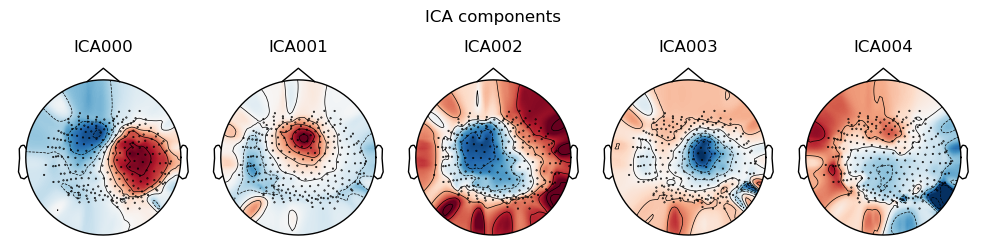

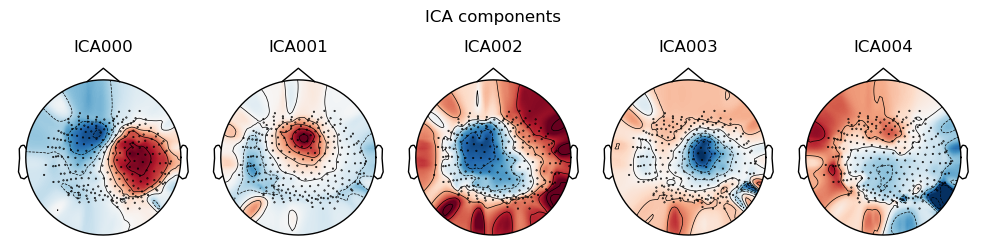

In [84]:
# Example for the first processed epoch
ica.fit(avg_raw)
sources = ica.get_sources(avg_raw)

# Plot the ICA components
ica.plot_components()

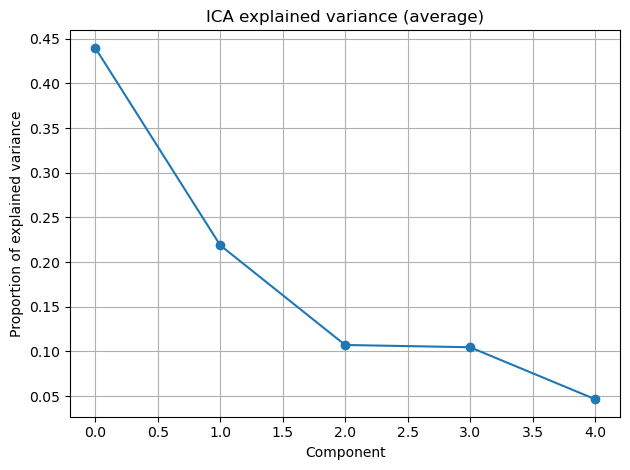

In [85]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot on the first axes
ax.plot([ica.get_explained_variance_ratio(avg_raw,components=[j for j in range(i,i+1)])['eeg'] for i in range(ica.n_components)], marker='o')
ax.set_title('ICA explained variance (average)')
ax.set_xlabel('Component')
ax.set_ylabel('Proportion of explained variance')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.grid()

# Show the plots
plt.show()

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 4 ICA components
    Projecting back using 253 PCA components


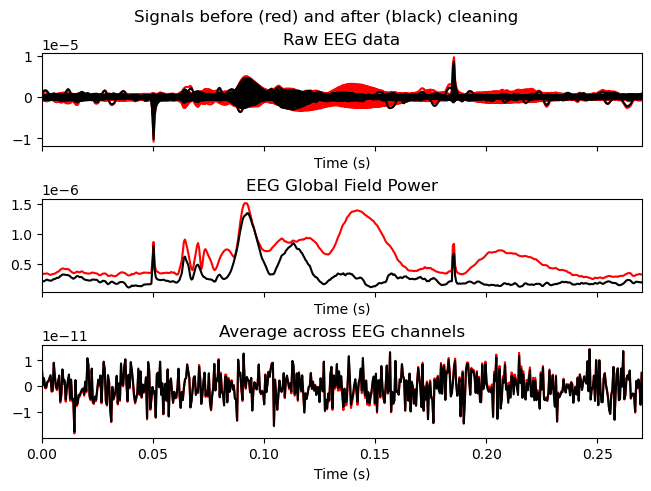

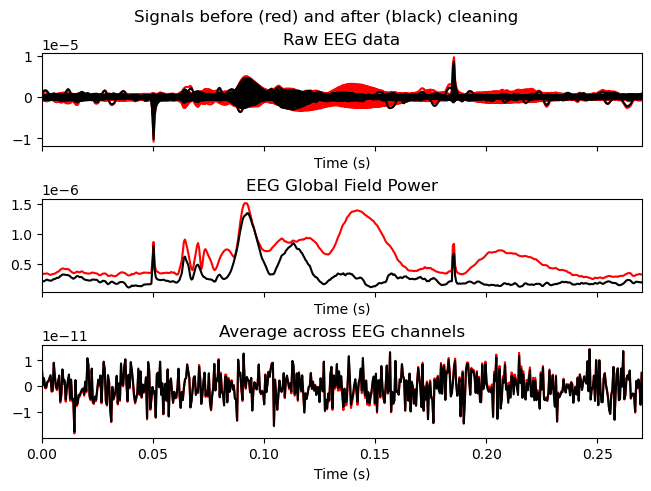

In [92]:
t1, t2 = -0.005-tmin, 0.038-tmin

ica.plot_overlay(avg_raw, exclude=[i for i in range(ica.n_components) if i != 1])

In [112]:
# Create raw out of an epoch. Maybe there's a better way to do this, or it's just unnecessary?

trial_n = 5

single_epoch_data = epochs.get_data(item=trial_n)
_, n_channels, n_times = single_epoch_data.shape

single_epoch_data = single_epoch_data.transpose(1,0,2).reshape(n_channels, n_times)

#info = single_epoch.info.copy()
#single_epoch_raw = mne.io.RawArray(single_epoch_data, info)

In [117]:
for epoch in epochs:
    if (epoch.event_id == trial_n):
        break

epoch

AttributeError: 'numpy.ndarray' object has no attribute 'event_id'

Fitting ICA to data using 253 channels (please be patient, this may take a while)
Selecting by number: 50 components
Fitting ICA took 0.2s.


/var/folders/88/5gz2l3qs4bz48czkqdqzhz1r0000gn/T/ipykernel_21856/2873821336.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(first_epoch_raw)


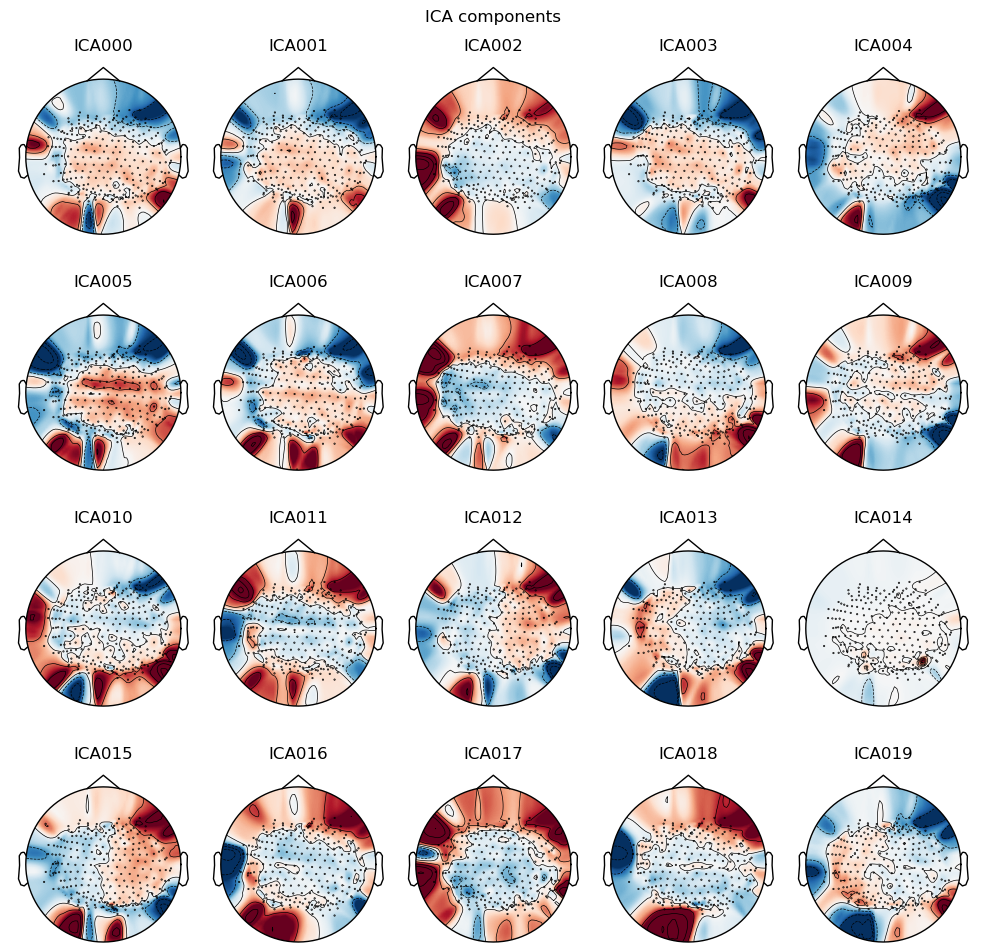

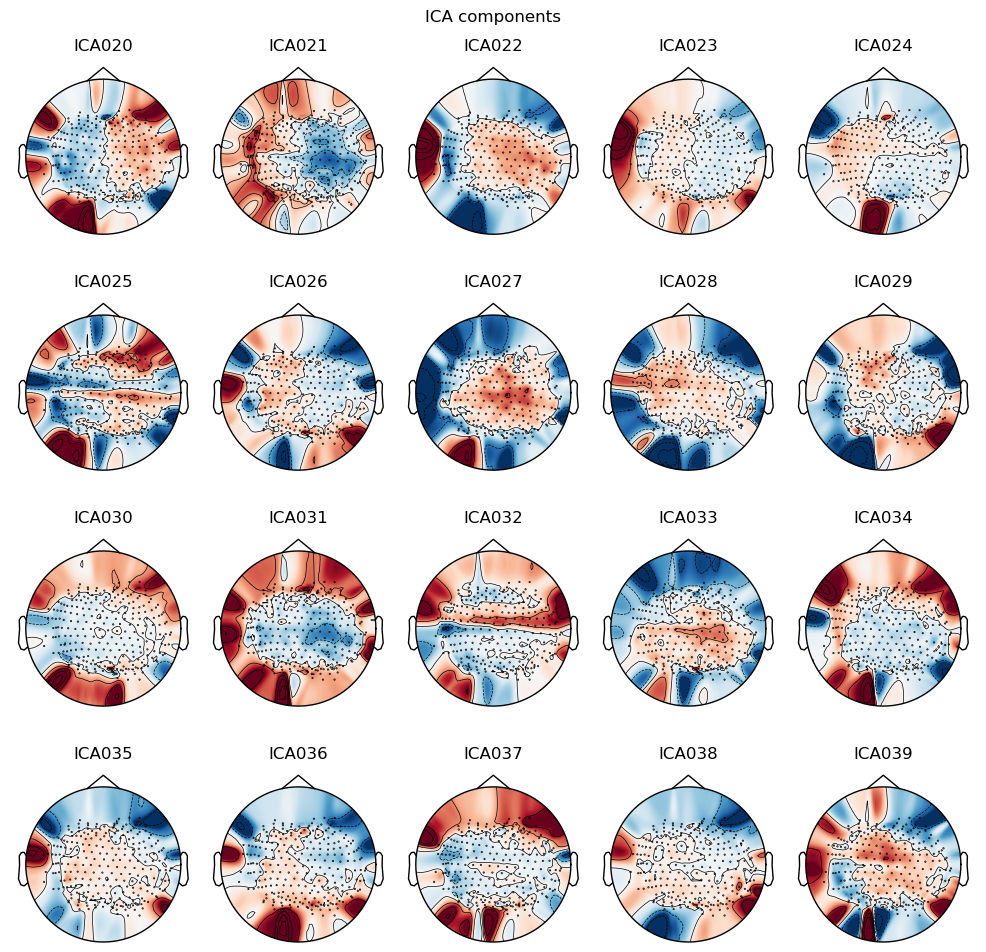

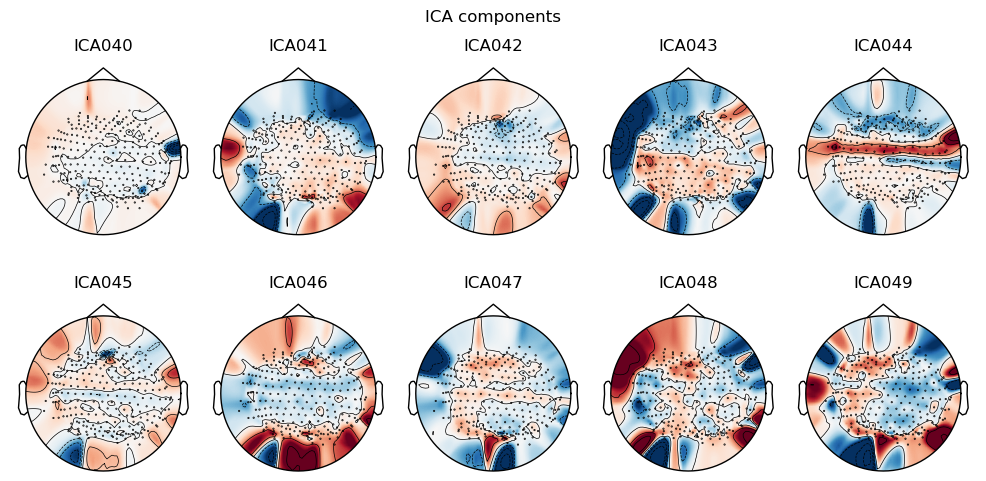

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x496 with 10 Axes>]

In [106]:
# Example for the first processed epoch
ica.fit(first_epoch_raw)
sources = ica.get_sources(first_epoch_raw)

# Plot the ICA components
ica.plot_components()

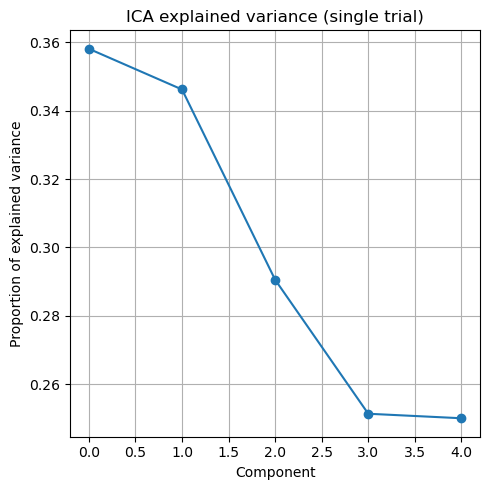

In [94]:
# Create a figure and axes
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plot on the first axes
ax.plot([ica.get_explained_variance_ratio(first_epoch_raw,components=[j for j in range(i,i+1)])['eeg'] for i in range(ica.n_components)], marker='o')
ax.set_title('ICA explained variance (single trial)')
ax.set_xlabel('Component')
ax.set_ylabel('Proportion of explained variance')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.grid()

# Show the plots
plt.show()

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 4 ICA components
    Projecting back using 253 PCA components


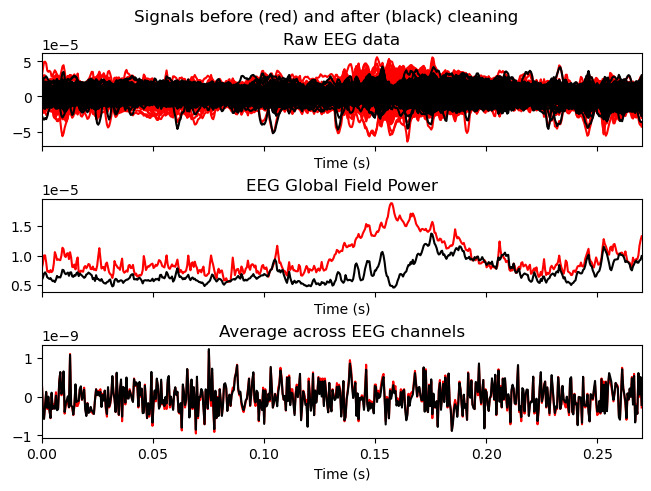

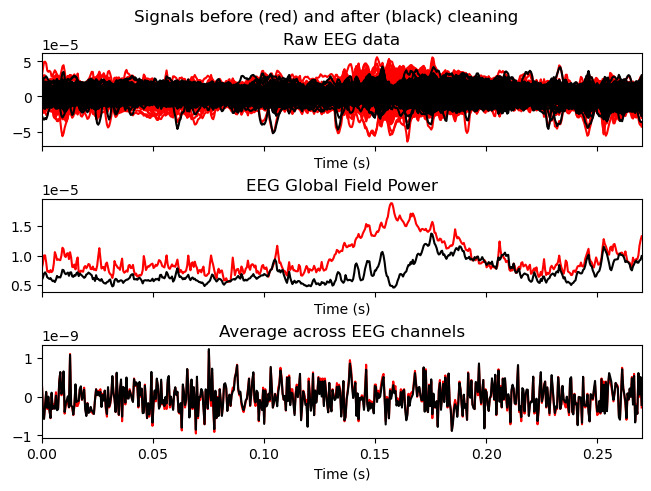

In [97]:
t1, t2 = -0.005-tmin, 0.038-tmin

ica.plot_overlay(first_epoch_raw, exclude=[i for i in range(ica.n_components) if i != 1])

In [10]:
reconstructed_data = first_epoch_raw.copy()
ica.apply(reconstructed_data, exclude=[i for i in range(2,15)])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 13 ICA components
    Projecting back using 253 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,256 points
Good channels,253 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,0.00 Hz
Lowpass,1024.00 Hz


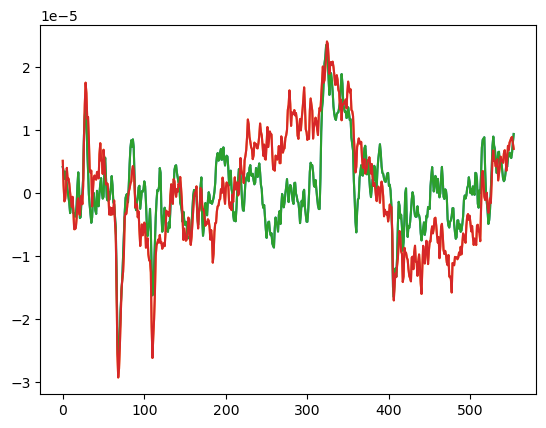

In [15]:
ch = 150
plt.plot(reconstructed_data.get_data()[ch])
plt.plot(first_epoch_raw.get_data()[ch])
plt.show()